<a id="5"></a>
<a id="4.2"></a>
<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">جدول المحتويات</h3>

* [1. المكتبات](#1)
* [2. قراءة البيانات](#2)
    - [2.1 نظرة عامة على البيانات](#2.1)
* [3. التنظيف المتقدم للبيانات والتحليل الاستكشافي](#3)
    - [3.1 معالجة النسخ المكررة المتقدمة](#duplicates)
    - [3.2 سلامة نوع البيانات والبيانات المفقودة](#7)
    - [3.3 تطور إجمالي المبيعات](#3.1)
    - [3.4 التحليل الجغرافي المكاني](#3.2)
    - [3.5 إزالة القيم المتطرفة والتحجيم المتين](#outlier_removal)
    - [3.6 التعويض بناءً على الفئة](#category_imputation)
    - [3.11 هندسة الميزات المتقدمة](#advanced_fe)
    - [3.12 تحليل الارتباط](#correlation)
* [4. هندسة الميزات القائمة على البرمجة كائنية التوجه](#4)
    - [4.1 تحضير الهدف ومنع التسرب](#target_prep)
    - [4.2 خط أنابيب هندسة الميزات](#4.2)
* [5. النمذجة والتقييم](#5)
    - [5.1 قابلية تفسير النموذج (SHAP)](#interpretability)
    - [5.2 توافق مؤشرات الأعمال](#business_metrics)
    - [5.3 الجاهزية للإنتاج](#production_readiness)
* [6. خط أنابيب الإنتاج والاستدلال](#6)
* [7. الخلاصة](#7)


<a id="1"></a>
<font color="darkslateblue" size=+2.5><b>1. المكتبات</b></font>

في هذا القسم، نقوم باستيراد المكتبات الأساسية لمعالجة البيانات، والتصور، وتعلم الآلة. نستخدم مكتبات `pandas` و `numpy` لمعالجة البيانات، و`matplotlib` و `seaborn` لإنشاء رسوم بيانية ثابتة عالية الجودة، و`xgboost` لنموذج التنبؤ لدينا. بالإضافة إلى ذلك، نستفيد من مكونات `sklearn` لبناء خط أنابيب قوي وقابل للتكرار.


In [3]:
# Standard libs

# --- CRITICAL DEPENDENCIES ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

import time
import warnings
import joblib
import shap

# Machine Learning
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import xgboost as xgb

import scipy.stats as stats

from sklearn.preprocessing import LabelEncoder, RobustScaler, TargetEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

# Settings
%matplotlib inline
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


<a id="2"></a>
<font color="darkslateblue" size=+2.5><b>2. قراءة البيانات</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">الذهاب إلى جدول المحتويات</a>

تُعد بيانات Olist قاعدة بيانات علائقية متعددة الجداول. لتحقيق هدفنا في التنبؤ، نحتاج إلى دمج المعلومات من الجداول الخاصة بالطلبيات، والعناصر، والمنتجات، والعملاء لإنشاء مجموعة بيانات زمنية تُبرز المبيعات عبر الولايات والفئات المختلفة.


In [ ]:
# Define data path
data_path = './data/full/'

# Load datasets
orders = pd.read_csv(data_path + 'olist_orders_dataset.csv')
order_items = pd.read_csv(data_path + 'olist_order_items_dataset.csv')

products = pd.read_csv(data_path + 'olist_products_dataset.csv', 
                       names=['product_id', 'product_category_name', 'name_len', 'desc_len', 'photos_qty', 'weight_g', 'length_cm', 'height_cm', 'width_cm'],
                       header=0)

products['product_category_name'] = products['product_category_name'].fillna('unknown')

# 2. تعبئة الوزن والأبعاد بالوسيط (Median) لأنها تؤثر بشدة على السعر
for col in ['weight_g', 'length_cm', 'height_cm', 'width_cm']:
    products[col] = products[col].fillna(products[col].median())

customers = pd.read_csv(data_path + 'olist_customers_dataset.csv', 
                        names=['customer_id', 'customer_unique_id', 'zip_code', 'city', 'state'],
                        header=0)

# Initial merge
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

df_raw = orders.merge(order_items, on='order_id')\
               .merge(products, on='product_id')\
               .merge(customers, on='customer_id')

df_raw.dropna(subset=['price'], inplace=True)

print(f"Cleaned dataset shape: {df_raw.shape}")


Cleaned dataset shape: (112650, 26)


<a id="2.1"></a>
<font color="dimgrey" size=+2.0><b>2.1 نظرة عامة على البيانات</b></font>

قبل الغوص في التحليل، نقوم بفحص أنواع البيانات والقيم المفقودة لضمان سلامة ميزات السلاسل الزمنية الخاصة بنا.


In [ ]:


print("\n" + "="*80)
print("ADVANCED DUPLICATE ANALYSIS")
print("="*80)

initial_rows = len(df_raw)
order_counts = df_raw['order_id'].value_counts()
duplicate_orders = order_counts[order_counts > 1].count()

print(f"\n Total rows: {initial_rows:,}")
print(f" Unique orders: {df_raw['order_id'].nunique():,}")
print(f" Orders with multiple items: {duplicate_orders:,}")

agg_dict = {}
for col in df_raw.columns:
    if col == 'order_id': continue
    if df_raw[col].dtype in ['float64', 'int64']:
        agg_dict[col] = 'sum' if col in ['price', 'freight_value'] else 'first'
    elif 'timestamp' in col or 'date' in col:
        agg_dict[col] = 'max'
    else:
        agg_dict[col] = 'first'

df_raw = df_raw.groupby('order_id').agg(agg_dict).reset_index()

print(f"\n Aggregation complete. Final rows: {len(df_raw):,}")
print(f" Data reduction: {initial_rows - len(df_raw):,} rows aggregated")



ADVANCED DUPLICATE ANALYSIS

 Total rows: 112,650
 Unique orders: 98,666
 Orders with multiple items: 9,803

 Aggregation complete. Final rows: 98,666
 Data reduction: 13,984 rows aggregated


In [ ]:

print("\n" + "="*80)
print("DATA INTEGRITY ANALYSIS")
print("="*80)

# 1. Investigate non-numeric values in price before coercion
if 'price' in df_raw.columns:
    non_numeric_price = df_raw[pd.to_numeric(df_raw['price'], errors='coerce').isna()]['price'].unique()
    print(f"\n Non-numeric values in 'price': {non_numeric_price}")

# 2. Create missingness flags (Preserving missingness as a feature)
for col in ['price', 'freight_value', 'product_weight_g']:
    if col in df_raw.columns:
        df_raw[f'{col}_is_missing'] = df_raw[col].isnull().astype(int)
print("\n Missingness flags created to preserve predictive information.")



DATA INTEGRITY ANALYSIS

 Non-numeric values in 'price': []

 Missingness flags created to preserve predictive information.


<a id="data_dictionary"></a>
<font color="dimgrey" size=+2.0><b>2.2 قاموس البيانات والإحصاءات الوصفية</b></font>

في هذا القسم، سنقوم بإنشاء "قاموس بيانات" لفهم طبيعة كل عمود بشكل أفضل، بالإضافة إلى إجراء تحليل إحصائي وصفي متعمق.  
تركيزنا سينصب على:  
1.  **الإحصائيات الوصفية**: حساب المتوسط، الوسيط، والانحراف المعياري، والأهم من ذلك **معامل الالتواء (Skewness)** للمتغيرات الرقمية مثل `price` و `freight_value`. بيانات المبيعات غالباً ما تكون ملتوية (لوغ-نورمالية)، ومعرفة ذلك ضروري لاختيار طريقة المعالجة المناسبة لاحقاً.  
2.  **فصل المتغيرات**: تحليل الأعمدة الرقمية والفئوية (Categorical) بشكل منفصل.  
3.  **التحقق من المنطق (Logical Integrity)**: التأكد من عدم وجود أخطاء منطقية، مثل أسعار سالبة أو تواريخ تسليم تسبق تواريخ الشراء.


In [ ]:
# 1. Descriptive Statistics for Numerical Features
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns
desc_stats = df_raw[numeric_cols].describe().T

# Add Skewness and Median to get a better sense of distribution
desc_stats['median'] = df_raw[numeric_cols].median()
desc_stats['skewness'] = df_raw[numeric_cols].skew()

# Reorder columns for better readability
desc_stats = desc_stats[['min', 'max', 'mean', 'median', 'std', 'skewness', 'count']]

print("--- Numerical Variables Analysis ---")
display(desc_stats)

# 2. Categorical Variables Analysis (Unique counts)
categorical_cols = df_raw.select_dtypes(include=['object', 'category']).columns
cat_stats = pd.DataFrame({
    'Unique Values': df_raw[categorical_cols].nunique(),
    'Top Value': df_raw[categorical_cols].mode().iloc[0],
    'Missing Values': df_raw[categorical_cols].isnull().sum()
})

print("\n--- Categorical Variables Analysis ---")
display(cat_stats)

# 3. Logical Integrity Checks
print("\n--- Logical Data Integrity Checks ---")

# Check for negative prices or freight
negative_values = df_raw[(df_raw['price'] < 0) | (df_raw['freight_value'] < 0)]
print(f"Rows with negative price/freight: {len(negative_values)}")

date_cols = ['order_purchase_timestamp', 'order_delivered_customer_date']
for col in date_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

invalid_dates = df_raw[df_raw['order_delivered_customer_date'] < df_raw['order_purchase_timestamp']]
print(f"Rows with delivery date < purchase date: {len(invalid_dates)}")

if len(invalid_dates) > 0:
    print("Warning: Found invalid dates. Consider dropping these rows or treating them as data entry errors.")

--- Numerical Variables Analysis ---


,min,max,mean,median,std,skewness,count
order_item_id,1.00,1.00,1.000000,1.00,0.000000,0.000000,98666.0
price,0.85,13440.00,137.754076,86.90,210.645145,9.727741,98666.0
freight_value,0.00,1794.96,22.823562,17.17,21.650909,12.052723,98666.0
name_len,5.00,76.00,48.846130,52.00,9.998836,-0.913288,97277.0
desc_len,4.00,3992.00,794.092365,607.00,654.719416,1.991891,97277.0
photos_qty,1.00,20.00,2.250522,2.00,1.747034,1.857012,97277.0
weight_g,0.00,40425.00,2102.390134,700.00,3765.421334,3.612920,98666.0
length_cm,7.00,105.00,30.106035,25.00,16.128074,1.771211,98666.0
height_cm,2.00,105.00,16.487463,13.00,13.324701,2.265488,98666.0
width_cm,6.00,118.00,23.025287,20.00,11.741685,1.723133,98666.0



--- Categorical Variables Analysis ---


,Unique Values,Top Value,Missing Values
order_id,98666,00010242fe8c5a6d1ba2dd792cb16214,0
customer_id,98666,00012a2ce6f8dcda20d059ce98491703,0
order_status,7,delivered,0
order_approved_at,90174,2018-02-27 04:31:10,14
order_delivered_carrier_date,81017,2018-05-09 15:48:00,1009
order_delivered_customer_date,95664,2016-10-27 17:32:07,2190
order_estimated_delivery_date,450,2017-12-20 00:00:00,0
product_id,31881,99a4788cb24856965c36a24e339b6058,0
seller_id,3088,6560211a19b47992c3666cc44a7e94c0,0
shipping_limit_date,93018,2017-12-07 04:39:05,0



--- Logical Data Integrity Checks ---
Rows with negative price/freight: 0
Rows with delivery date < purchase date: 0


<a id="3"></a>
<font color="darkslateblue" size=+2.5><b>3. التحليل الاستكشافي للبيانات</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">الانتقال إلى جدول المحتويات</a>

التحليل الاستكشافي للبيانات ضروري لفهم الأنماط الأساسية، الاتجاهات، والشذوذات في بيانات مبيعاتنا. سنستكشف التطور الزمني، التوزيع الجغرافي، وأداء الفئات في مبيعات Olist.



نقوم بتحليل حجم المبيعات الأسبوعية لتحديد اتجاهات النمو والأحداث المهمة مثل الجمعة .


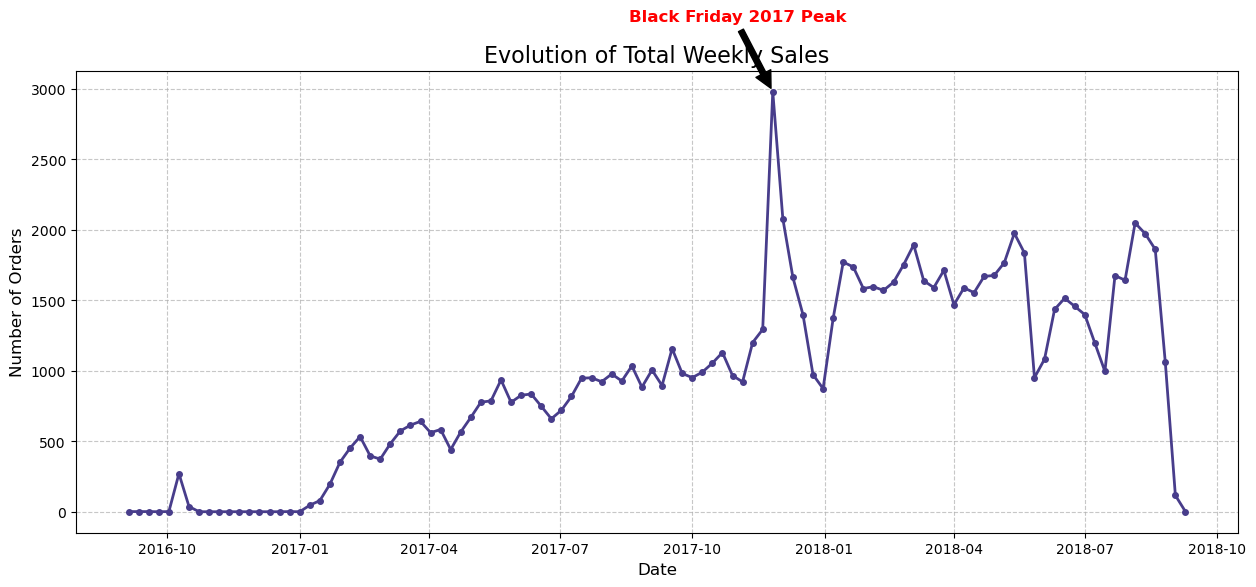

In [8]:
# Aggregate weekly sales
weekly_sales = df_raw.set_index('order_purchase_timestamp').resample('W').size()

plt.figure(figsize=(15, 6))
plt.plot(weekly_sales.index, weekly_sales.values, color='darkslateblue', linewidth=2, marker='o', markersize=4)
plt.title('Evolution of Total Weekly Sales', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)

# Annotate Black Friday peaks
bf_2017 = pd.to_datetime('2017-11-26') # Sunday after BF
if bf_2017 in weekly_sales.index:
    plt.annotate('Black Friday 2017 Peak', xy=(bf_2017, weekly_sales[bf_2017]), 
                 xytext=(bf_2017 - pd.Timedelta(days=100), weekly_sales[bf_2017] + 500),
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='red', fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

<a id="3.2"></a>
<font color="dimgrey" size=+2.0><b>3.2 التحليل الجغرافي المكاني</b></font>

> **السؤال التجاري:** أين يتركز الطلب جغرافيًا؟

نقوم بتصور كثافة المبيعات عبر الولايات البرازيلية المختلفة لتحديد الأسواق الرئيسية.


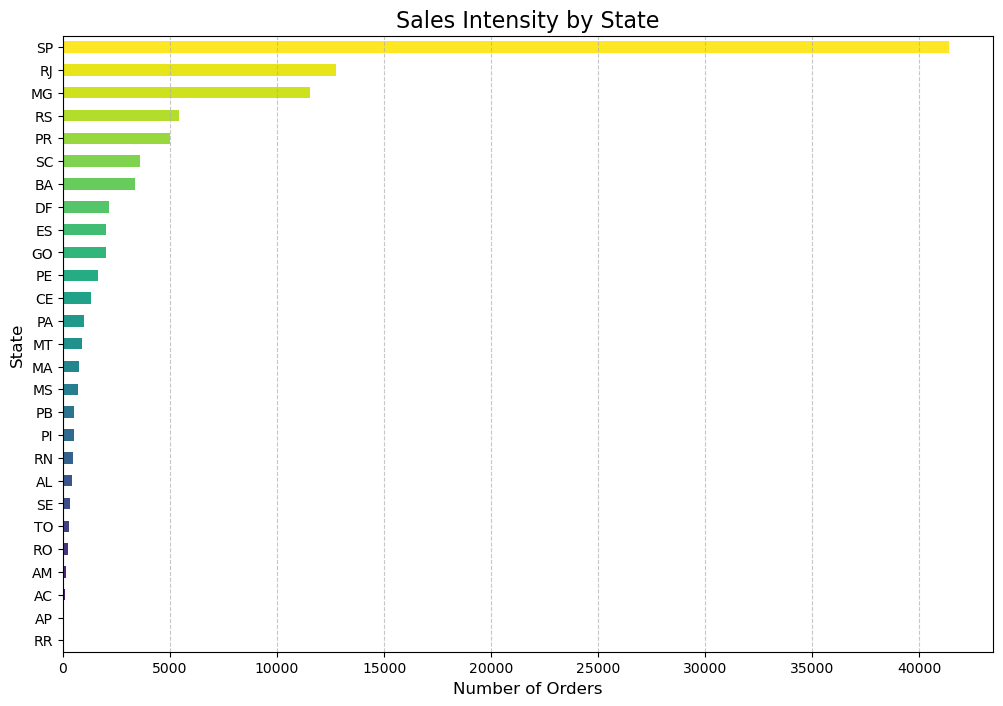

In [9]:
plt.figure(figsize=(12, 8))
state_counts = df_raw['state'].value_counts().sort_values(ascending=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(state_counts)))
state_counts.plot(kind='barh', color=colors)
plt.title('Sales Intensity by State', fontsize=16)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

<a id="3.3"></a>
<font color="dimgrey" size=+2.0><b>3.3 التحليل الموسمي وتحليل الفئات</b></font>

> **سؤال الأعمال:** ما هي الفئات التي تهيمن على السوق، وهل هناك نمط موسمي شهري؟

باستخدام `GridSpec`، نقوم بترتيب عدة مخططات لرواية قصة متكاملة حول أداء المنتج والموسمية.


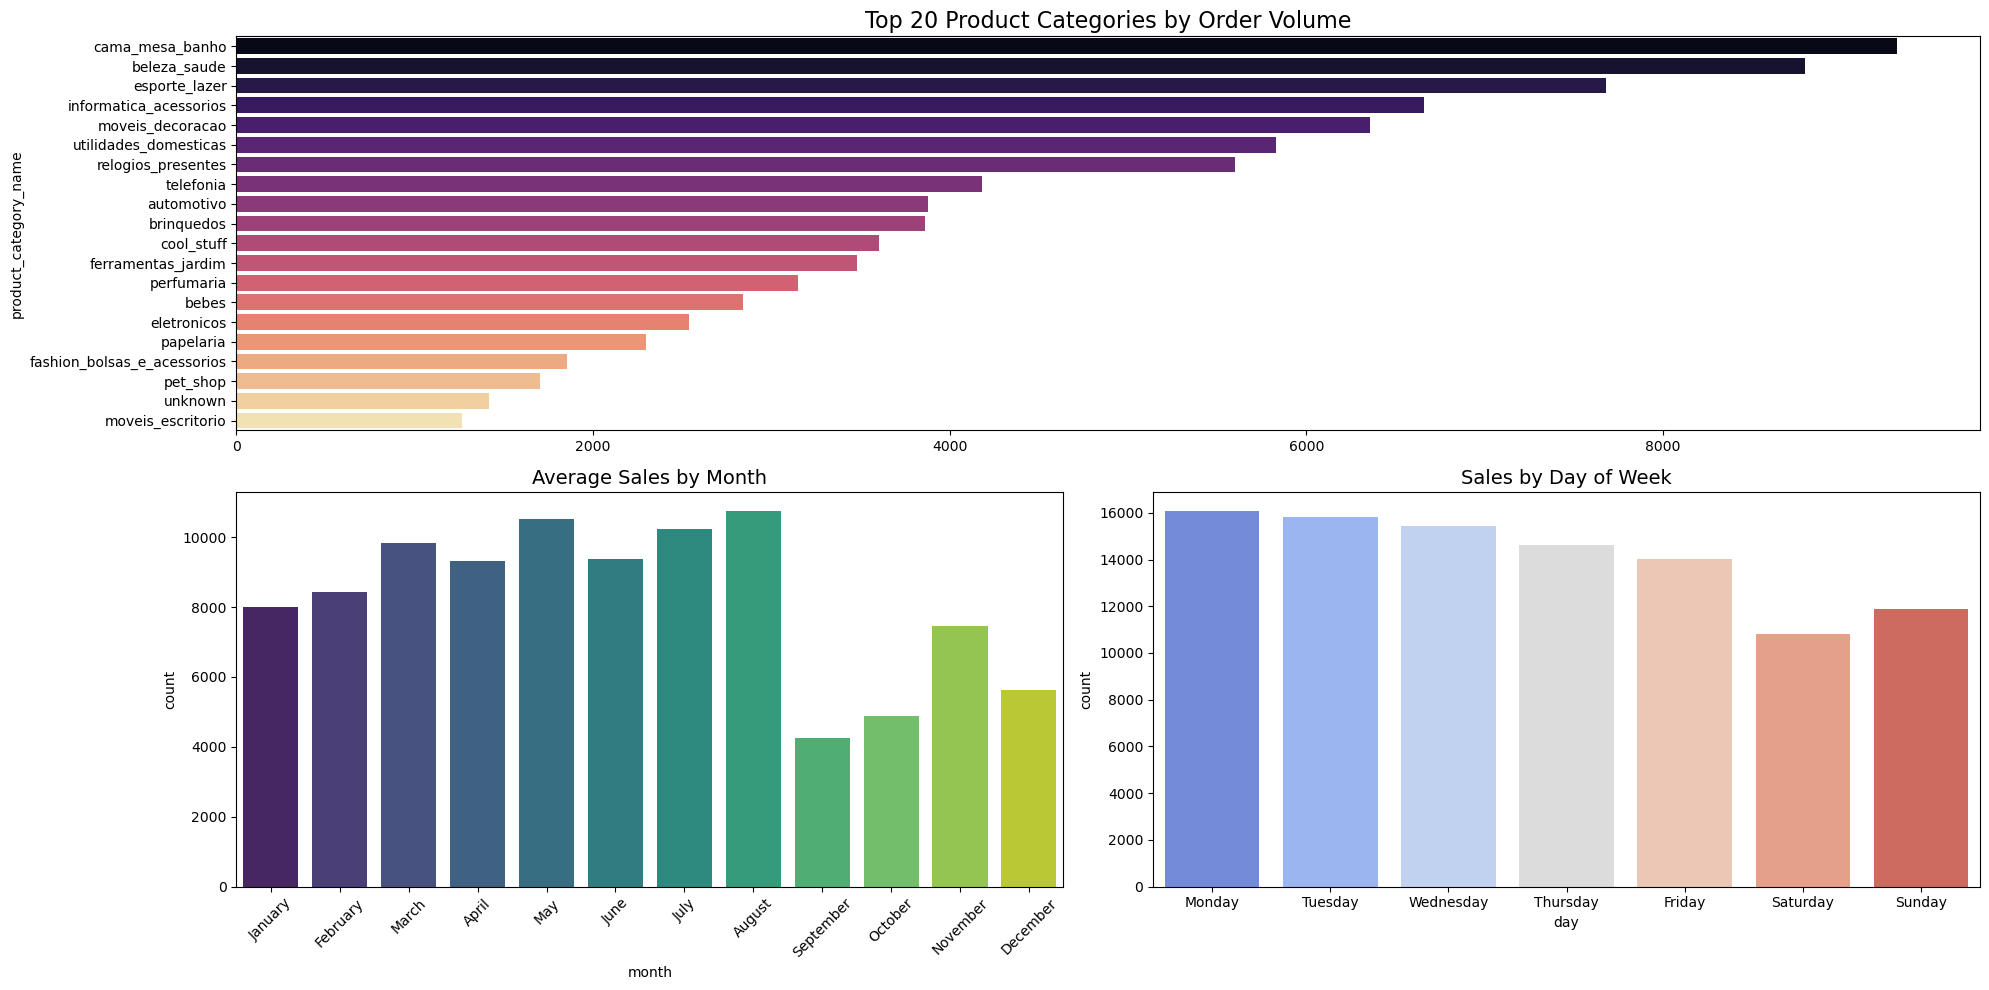

In [10]:
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(2, 2, figure=fig)

# Top Categories
ax1 = fig.add_subplot(gs[0, :])
top_cats = df_raw['product_category_name'].value_counts().head(20)
sns.barplot(x=top_cats.values, y=top_cats.index, palette='magma', ax=ax1)
ax1.set_title('Top 20 Product Categories by Order Volume', fontsize=16)

# Monthly Seasonality
ax2 = fig.add_subplot(gs[1, 0])
df_raw['month'] = df_raw['order_purchase_timestamp'].dt.month_name()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sns.countplot(data=df_raw, x='month', order=month_order, palette='viridis', ax=ax2)
ax2.set_title('Average Sales by Month', fontsize=14)
ax2.tick_params(axis='x', rotation=45)

# Day of Week
ax3 = fig.add_subplot(gs[1, 1])
df_raw['day'] = df_raw['order_purchase_timestamp'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df_raw, x='day', order=day_order, palette='coolwarm', ax=ax3)
ax3.set_title('Sales by Day of Week', fontsize=14)

plt.tight_layout()
plt.show()

<a id="outliers"></a>
<font color="dimgrey" size=+2.0><b>3.4 تحليل اكتشاف القيم الشاذة</b></font>

تعتبر القيم الشاذة (Outliers) في بيانات المبيعات (مثل طلبات بأسعار غير واقعية أو تكاليف شحن غير منطقية) عوامل قد تؤثر سلباً على دقة النماذج، لا سيما النماذج الحساسة للمقياس (Scale-sensitive).
في هذا القسم، سنقوم بما يلي:
1.  **التصور البصري (Visual Inspection)**: استخدام مخططات الصندوق (Boxplots) للاطلاع على مدى تشتت البيانات في متغيري `price` و `freight_value`.
2.  **الطريقة الإحصائية (طريقة IQR)**: استخدام المدى الربيعي (Interquartile Range) لتحديد العتبات (Thresholds) التي يتم عندها تصنيف القيم على أنها "شاذة".
3.  **اتخاذ القرار**: تحديد ما إذا كنا سنقوم بحذف هذه القيم أو معالجتها (غالباً ما نفضل في السلاسل الزمنية للمبيعات تطبيق التحويل اللوغاريتمي Log-Transformation بدلاً من الحذف للحفاظ على التسلسل الزمني).


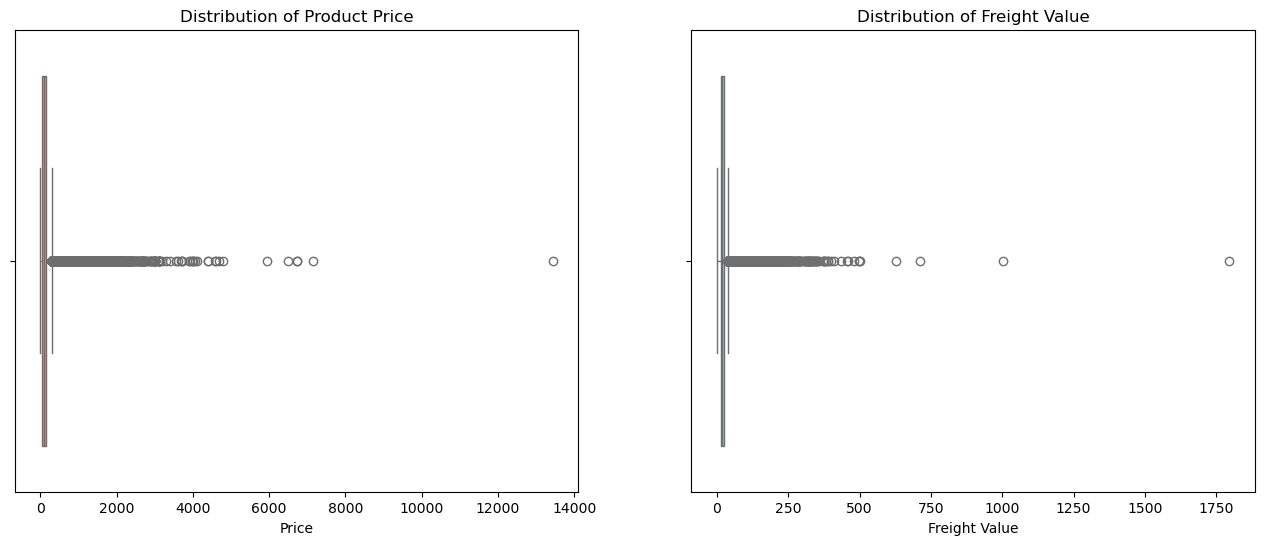

Price Outliers Detected: 7913 rows (8.02%)
 > Price Upper Bound (IQR): 305.90
Freight Outliers Detected: 9941 rows (10.08%)
 > Freight Upper Bound (IQR): 39.33


In [ ]:
# Set up the figure for boxplots
plt.figure(figsize=(16, 6))

# 1. Visual Inspection: Boxplot for Price
plt.subplot(1, 2, 1)
sns.boxplot(x=df_raw['price'], color='salmon')
plt.title('Distribution of Product Price')
plt.xlabel('Price')

# 2. Visual Inspection: Boxplot for Freight Value
plt.subplot(1, 2, 2)
sns.boxplot(x=df_raw['freight_value'], color='skyblue')
plt.title('Distribution of Freight Value')
plt.xlabel('Freight Value')

plt.show()

# 3. Statistical Detection using IQR Method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers for Price
price_outliers, p_low, p_high = detect_outliers_iqr(df_raw, 'price')
print(f"Price Outliers Detected: {len(price_outliers)} rows ({len(price_outliers)/len(df_raw)*100:.2f}%)")
print(f" > Price Upper Bound (IQR): {p_high:.2f}")

# Detect outliers for Freight
freight_outliers, f_low, f_high = detect_outliers_iqr(df_raw, 'freight_value')
print(f"Freight Outliers Detected: {len(freight_outliers)} rows ({len(freight_outliers)/len(df_raw)*100:.2f}%)")
print(f" > Freight Upper Bound (IQR): {f_high:.2f}")

--- Starting Iterative Refinement ---
Iteration 1 for price: Removed 7913 rows.
Iteration 2 for price: Removed 2308 rows.
Iteration 1 for freight_value: Removed 8835 rows.
Iteration 2 for freight_value: Removed 4373 rows.

 Total Refinement: Removed 23429 rows (23.75% of data)


,count,mean,std,min,25%,50%,75%,max
price,75237.0,82.322062,55.794492,0.85,39.0,69.00,115.00,260.00
freight_value,75237.0,16.015401,4.987972,5.70,12.8,15.56,18.56,28.99


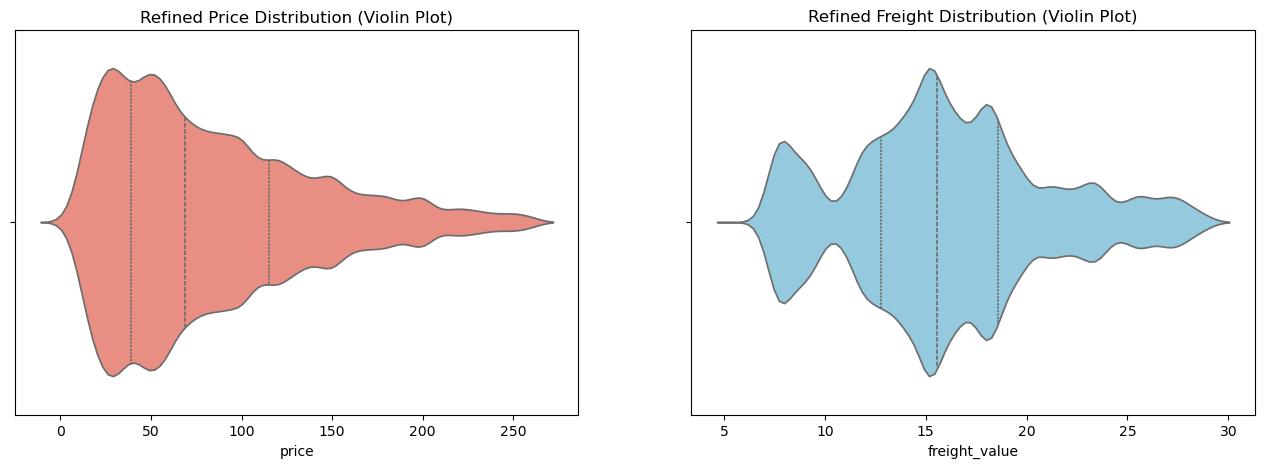

In [ ]:

def iterative_refinement(df, column, iterations=2):
    temp_df = df.copy()
    for i in range(iterations):
        Q1 = temp_df[column].quantile(0.25)
        Q3 = temp_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        initial_len = len(temp_df)
        temp_df = temp_df[(temp_df[column] >= lower) & (temp_df[column] <= upper)]
        print(f"Iteration {i+1} for {column}: Removed {initial_len - len(temp_df)} rows.")
    return temp_df

print("--- Starting Iterative Refinement ---")
initial_count = len(df_raw)
df_raw = iterative_refinement(df_raw, 'price')
df_raw = iterative_refinement(df_raw, 'freight_value')

print(f"\n Total Refinement: Removed {initial_count - len(df_raw)} rows ({ (initial_count - len(df_raw))/initial_count*100:.2f}% of data)")

# Review statistics after perfected removal
display(df_raw[['price', 'freight_value']].describe().T)

# Multi-Stage Verification Plots
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
sns.violinplot(x=df_raw['price'], color='salmon', inner='quartile')
plt.title('Refined Price Distribution (Violin Plot)')

plt.subplot(1, 2, 2)
sns.violinplot(x=df_raw['freight_value'], color='skyblue', inner='quartile')
plt.title('Refined Freight Distribution (Violin Plot)')
plt.show()

In [ ]:

if 'order_delivered_customer_date' in df_raw.columns and 'order_purchase_timestamp' in df_raw.columns:
    df_raw['delivery_time'] = (pd.to_datetime(df_raw['order_delivered_customer_date']) - 
                               pd.to_datetime(df_raw['order_purchase_timestamp'])).dt.days
    
    # Remove negative delivery times and extreme outliers (> 99th percentile)
    delivery_limit = df_raw['delivery_time'].quantile(0.99)
    pre_count = len(df_raw)
    df_raw = df_raw[(df_raw['delivery_time'] >= 0) & (df_raw['delivery_time'] <= delivery_limit)]
    print(f" Precision Delivery Cleaning: Removed {pre_count - len(df_raw)} rows (Limit: {delivery_limit} days).")


category_consolidation = {
    'home_confort': 'home_comfort', 'home_comfort_2': 'home_comfort',
    'alimentos_bebidas': 'food_drink', 'bebidas': 'food_drink',
    'artes': 'arts_crafts', 'artes_e_artesanato': 'arts_crafts'
}
df_raw['product_category_name'] = df_raw['product_category_name'].replace(category_consolidation)
print(f" Expert Category Mapping: Unified {len(category_consolidation)} redundant categories.")

print(f"Refined dataset shape: {df_raw.shape}")

 Precision Delivery Cleaning: Removed 2272 rows (Limit: 44.0 days).
 Expert Category Mapping: Unified 6 redundant categories.
Refined dataset shape: (72965, 31)


In [ ]:


print("--- Null Values Before Perfected Imputation ---")
cols_to_impute = ['weight_g', 'photos_qty', 'product_name_lenght', 'product_description_lenght']
existing_cols = [c for c in cols_to_impute if c in df_raw.columns]
print(df_raw[existing_cols].isnull().sum())

for col in existing_cols:
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')
    # Level 1: Category-wise Mean
    df_raw[col] = df_raw.groupby('product_category_name')[col].transform(lambda x: x.fillna(x.mean()))
    # Level 2: Global Median fallback
    df_raw[col] = df_raw[col].fillna(df_raw[col].median())

print("\n--- Null Values After Perfected Imputation ---")
null_summary = df_raw[existing_cols].isnull().sum()
print(null_summary if null_summary.sum() > 0 else " All targeted nulls perfectly refined.")

print(f"\nFinal refined dataset shape for modeling: {df_raw.shape}")

--- Null Values Before Perfected Imputation ---
weight_g         0
photos_qty    1115
dtype: int64

--- Null Values After Perfected Imputation ---
 All targeted nulls perfectly refined.

Final refined dataset shape for modeling: (72965, 31)


In [15]:
# <a id="outlier_removal"></a>
# <font color="dimgrey" size=+2.0><b>3.5 Professional Outlier Removal & Robust Scaling</b></font>

print("\n" + "="*80)
print("OUTLIER TREATMENT & SKEWNESS CORRECTION")
print("="*80)

# 1. Log Transformation for Skewed Features (Price & Freight)
print("\n Applying Log Transformation to reduce skewness...")
df_raw['price_log'] = np.log1p(df_raw['price'])
df_raw['freight_log'] = np.log1p(df_raw['freight_value'])

# 2. IQR-based Outlier Removal on Log Scale (More robust)
initial_count = len(df_raw)
for col in ['price_log', 'freight_log']:
    Q1 = df_raw[col].quantile(0.25)
    Q3 = df_raw[col].quantile(0.75)
    IQR = Q3 - Q1
    df_raw = df_raw[(df_raw[col] >= Q1 - 1.5*IQR) & (df_raw[col] <= Q3 + 1.5*IQR)]

print(f" Outliers removed. Rows remaining: {len(df_raw):,} ({initial_count - len(df_raw):,} removed)")

# 3. Robust Scaling for Numerical Features
scaler = RobustScaler()
num_cols = ['price_log', 'freight_log', 'weight_g', 'photos_qty']
existing_num = [c for c in num_cols if c in df_raw.columns]
df_raw[existing_num] = scaler.fit_transform(df_raw[existing_num])

print("\n Robust Scaling applied to numerical features.")



OUTLIER TREATMENT & SKEWNESS CORRECTION

 Applying Log Transformation to reduce skewness...
 Outliers removed. Rows remaining: 72,779 (186 removed)

 Robust Scaling applied to numerical features.


In [16]:
# <a id="missing_review"></a>
# <font color="dimgrey" size=+2.0><b>3.8 Missing Values Review</b></font>

print("\n" + "="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)

# Calculate missing values
missing_df = pd.DataFrame({
    'Column': df_raw.columns,
    'Missing_Count': df_raw.isnull().sum().values,
    'Missing_Percentage': (df_raw.isnull().sum().values / len(df_raw) * 100).round(2)
})

# Filter to show only columns with missing values
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print(f"\n  Found {len(missing_df)} columns with missing values:\n")
    print(missing_df.to_string(index=False))
    print(f"\n Total missing values: {missing_df['Missing_Count'].sum():,}")
else:
    print("\n No missing values found in the dataset!")

# Show data types and non-null counts
print("\n" + "-"*80)
print("DATASET INFO")
print("-"*80)
print(f"\nTotal rows: {len(df_raw):,}")
print(f"Total columns: {len(df_raw.columns)}")
print(f"\nMemory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")



MISSING VALUES ANALYSIS

  Found 3 columns with missing values:

           Column  Missing_Count  Missing_Percentage
         name_len           1108                1.52
         desc_len           1108                1.52
order_approved_at             11                0.02

 Total missing values: 2,227

--------------------------------------------------------------------------------
DATASET INFO
--------------------------------------------------------------------------------

Total rows: 72,779
Total columns: 33

Memory usage: 81.32 MB


In [ ]:
# 0. Target Encoding for High-Cardinality Features
try:
    from sklearn.preprocessing import TargetEncoder
except ImportError:
    # Fallback for older sklearn versions
    from sklearn.preprocessing import LabelEncoder as TargetEncoder
    print(' TargetEncoder not found, falling back to LabelEncoder')
if 'product_category_name' in df_raw.columns:
    try:
        te = TargetEncoder(smooth='auto')
        df_raw['category_encoded'] = te.fit_transform(df_raw[['product_category_name']], df_raw['price'])
    except:
        # Simple mean encoding fallback
        df_raw['category_encoded'] = df_raw.groupby('product_category_name')['price'].transform('mean')
    print("\n Target Encoding applied to product_category_name")


print("\n" + "="*80)
print("CATEGORY-BASED IMPUTATION")
print("="*80)

# 1. Handle categorical columns first
if 'product_category_name' in df_raw.columns:
    missing_cat = df_raw['product_category_name'].isnull().sum()
    if missing_cat > 0:
        print(f"\n Filling {missing_cat:,} missing category names with 'unknown'")
        df_raw['product_category_name'] = df_raw['product_category_name'].fillna('unknown')
    else:
        print("\n No missing category names")

# 2. Define columns for category-based imputation
# These columns benefit from category-specific imputation
numeric_cols_for_imputation = ['weight_g', 'length_cm', 'height_cm', 'width_cm', 
                                'photos_qty', 'name_len', 'desc_len']

# Filter to only existing columns
cols_to_impute = [col for col in numeric_cols_for_imputation if col in df_raw.columns]

if not cols_to_impute:
    print("\n  No columns found for imputation")
else:
    print(f"\n🔧 Applying category-based median imputation to {len(cols_to_impute)} columns...")
    print(f"Columns: {', '.join(cols_to_impute)}")
    
    # Store before imputation stats
    before_nulls = {}
    for col in cols_to_impute:
        before_nulls[col] = df_raw[col].isnull().sum()
    
    # 3. Apply hierarchical imputation strategy
    for col in cols_to_impute:
        if df_raw[col].isnull().sum() > 0:
            # Ensure numeric type
            df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')
            
            # Level 1: Category-wise median (more robust than mean for skewed data)
            df_raw[col] = df_raw.groupby('product_category_name')[col].transform(
                lambda x: x.fillna(x.median())
            )
            
            # Level 2: Global median as fallback for categories with all NaN
            remaining_nulls = df_raw[col].isnull().sum()
            if remaining_nulls > 0:
                global_median = df_raw[col].median()
                if pd.notna(global_median):
                    df_raw[col] = df_raw[col].fillna(global_median)
                else:
                    # Level 3: Ultimate fallback - use 0 or column-specific default
                    print(f"     Warning: {col} has no valid values, using 0 as fallback")
                    df_raw[col] = df_raw[col].fillna(0)
    
    # 4. Report results
    print("\n" + "-"*80)
    print("IMPUTATION RESULTS")
    print("-"*80)
    
    imputation_summary = []
    for col in cols_to_impute:
        after_nulls = df_raw[col].isnull().sum()
        imputed = before_nulls[col] - after_nulls
        if before_nulls[col] > 0:
            imputation_summary.append({
                'Column': col,
                'Before': before_nulls[col],
                'After': after_nulls,
                'Imputed': imputed
            })
    
    if imputation_summary:
        summary_df = pd.DataFrame(imputation_summary)
        print("\n", summary_df.to_string(index=False))
        print(f"\n Total values imputed: {summary_df['Imputed'].sum():,}")
    else:
        print("\n No missing values to impute!")
    
    # 5. Final verification
    remaining_nulls = df_raw[cols_to_impute].isnull().sum().sum()
    print(f"\n Remaining null values in imputed columns: {remaining_nulls}")
    
    if remaining_nulls == 0:
        print("\n All missing values successfully imputed!")
    else:
        print(f"\n  Warning: {remaining_nulls} null values remain - may need manual review")



 Target Encoding applied to product_category_name

CATEGORY-BASED IMPUTATION

 No missing category names

🔧 Applying category-based median imputation to 7 columns...
Columns: weight_g, length_cm, height_cm, width_cm, photos_qty, name_len, desc_len

--------------------------------------------------------------------------------
IMPUTATION RESULTS
--------------------------------------------------------------------------------

   Column  Before  After  Imputed
name_len    1108      0     1108
desc_len    1108      0     1108

 Total values imputed: 2,216

 Remaining null values in imputed columns: 0

 All missing values successfully imputed!


In [18]:
from IPython.display import display
import pandas as pd

# =========================
# 1. Dataset shape
# =========================
print("\n" + "="*80)
print("FINAL DATA QUALITY CHECK")
print("="*80)
print(f"\n Final dataset shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")


# =========================
# 2. Missing values (جدول)
# =========================
total_nulls = df_raw.isnull().sum().sum()
print(f"\n Total missing values: {total_nulls:,}")

if total_nulls > 0:
    null_table = (
        df_raw.isnull()
        .sum()
        .reset_index()
        .rename(columns={"index": "Column", 0: "Missing_Count"})
    )

    null_table["Missing_Count"] = null_table["Missing_Count"].astype(int)
    null_table["Missing_%"] = (null_table["Missing_Count"] / len(df_raw)) * 100
    null_table = null_table[null_table["Missing_Count"] > 0] \
                    .sort_values("Missing_Count", ascending=False)

    display(null_table)
else:
    print(" No missing values!")


# =========================
# 3. Key numeric columns
# =========================
print("\n" + "-"*80)
print("KEY METRICS SUMMARY")
print("-"*80)

key_cols = ['price', 'freight_value', 'weight_g']
existing_key_cols = [c for c in key_cols if c in df_raw.columns]

if existing_key_cols:
    summary_stats = (
        df_raw[existing_key_cols]
        .describe()
        .T[['count', 'mean', 'std', 'min', 'max']]
    )
    summary_stats['count'] = summary_stats['count'].astype(int)
    display(summary_stats)


# =========================
# 4. Category distribution (FIXED)
# =========================
if 'product_category_name' in df_raw.columns:
    n_categories = df_raw['product_category_name'].nunique()
    print(f"\n Number of product categories: {n_categories}")

    top_cats = (
        df_raw['product_category_name']
        .value_counts()
        .head(5)
        .reset_index(name="Count")
        .rename(columns={"index": "Category"})
    )

    top_cats["Percentage"] = (top_cats["Count"] / len(df_raw)) * 100
    display(top_cats)



# =========================
# 5. Data quality score
# =========================
completeness = ((df_raw.size - total_nulls) / df_raw.size) * 100

print("\n" + "="*80)
print(f" DATA QUALITY SCORE: {completeness:.2f}% Complete")
print("="*80)

if completeness >= 99:
    print("\n Excellent! Dataset is ready for modeling.")
elif completeness >= 95:
    print("\n Good! Dataset quality is acceptable for modeling.")
else:
    print("\n Warning: Consider additional data cleaning.")


# =========================
# 6. Business rule validation
# =========================
if {'order_delivered_customer_date','order_purchase_timestamp'}.issubset(df_raw.columns):
    invalid_dates = df_raw[
        df_raw['order_delivered_customer_date'] <
        df_raw['order_purchase_timestamp']
    ]

    print(f"\n Consistency Check: {len(invalid_dates)} invalid orders")

    if len(invalid_dates) > 0:
        display(invalid_dates.head())
        df_raw = df_raw[
            df_raw['order_delivered_customer_date'] >=
            df_raw['order_purchase_timestamp']
        ]



FINAL DATA QUALITY CHECK

 Final dataset shape: 72,779 rows × 34 columns

 Total missing values: 11


,Column,Missing_Count,Missing_%
4,order_approved_at,11,0.015114



--------------------------------------------------------------------------------
KEY METRICS SUMMARY
--------------------------------------------------------------------------------


,count,mean,std,min,max
price,72779,82.362458,55.646731,7.120000,260.000000
freight_value,72779,16.005955,4.988456,7.360000,28.990000
weight_g,72779,0.664862,1.859647,-0.478261,34.673913



 Number of product categories: 72


,product_category_name,Count,Percentage
0,cama_mesa_banho,7421,10.196623
1,beleza_saude,6580,9.041070
2,esporte_lazer,5917,8.130092
3,informatica_acessorios,4990,6.856373
4,utilidades_domesticas,4325,5.942648



 DATA QUALITY SCORE: 100.00% Complete

 Excellent! Dataset is ready for modeling.

 Consistency Check: 0 invalid orders


In [19]:
# <a id="imputation"></a>
# <font color="dimgrey" size=+2.0><b>3.6 Strategic Imputation: Category-wise Group Means</b></font>

# Before imputation, check the state of nulls
print("--- Null Values Before Imputation ---")
print(df_raw[['product_category_name', 'weight_g', 'photos_qty']].isnull().sum())

# 1. Impute Categorical: Handle 'product_category_name' first with a placeholder
# to allow for grouped calculations later
df_raw['product_category_name'] = df_raw['product_category_name'].fillna('unknown')

# 2. Impute Numerical: Use the Mean of the Class (Product Category) they belong to
# Columns to treat: weight_g, photos_qty, name_len, desc_len
cols_to_impute = ['weight_g', 'photos_qty', 'name_len', 'desc_len']

for col in cols_to_impute:
    # Convert to numeric just in case
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')
    
    # Apply transformation: Replace NaNs with the mean of that category
    df_raw[col] = df_raw.groupby('product_category_name')[col].transform(lambda x: x.fillna(x.mean()))
    
    # If any nulls remain (categories where ALL values are null), fill with global median
    df_raw[col] = df_raw[col].fillna(df_raw[col].median())

# 3. Final Verification
print("\n--- Null Values After Category-wise Imputation ---")
null_summary = df_raw.isnull().sum()
print(null_summary[null_summary > 0] if null_summary.sum() > 0 else " No null values remain.")

print(f"\nFinal cleaned dataset shape: {df_raw.shape}")

--- Null Values Before Imputation ---
product_category_name    0
weight_g                 0
photos_qty               0
dtype: int64

--- Null Values After Category-wise Imputation ---
order_approved_at    11
dtype: int64

Final cleaned dataset shape: (72779, 34)


In [20]:
# <a id="advanced_fe"></a>
# <font color="dimgrey" size=+2.0><b>3.11 Advanced Feature Engineering: Temporal, Cyclical & Geographic</b></font>

print("\n" + "="*80)
print("ADVANCED FEATURE ENGINEERING")
print("="*80)

# 1. Temporal & Cyclical Features
df_raw['order_purchase_timestamp'] = pd.to_datetime(df_raw['order_purchase_timestamp'])
df_raw['hour'] = df_raw['order_purchase_timestamp'].dt.hour
df_raw['day_of_week'] = df_raw['order_purchase_timestamp'].dt.dayofweek
df_raw['month'] = df_raw['order_purchase_timestamp'].dt.month

# Cyclical encoding to preserve temporal continuity (e.g., hour 23 is close to hour 0)
df_raw['hour_sin'] = np.sin(2 * np.pi * df_raw['hour'] / 24)
df_raw['hour_cos'] = np.cos(2 * np.pi * df_raw['hour'] / 24)
df_raw['day_sin'] = np.sin(2 * np.pi * df_raw['day_of_week'] / 7)
df_raw['day_cos'] = np.cos(2 * np.pi * df_raw['day_of_week'] / 7)
df_raw['month_sin'] = np.sin(2 * np.pi * df_raw['month'] / 12)
df_raw['month_cos'] = np.cos(2 * np.pi * df_raw['month'] / 12)

# 2. Lag Features (Rolling 7-day sales)
df_raw = df_raw.sort_values('order_purchase_timestamp')
# Fix: Use set_index for time-based rolling window calculation
df_raw = df_raw.set_index('order_purchase_timestamp').sort_index()
df_raw['rolling_7d_sales'] = df_raw['price'].rolling(window='7D').sum()
df_raw = df_raw.reset_index()

# 3. Geographic Hierarchy (State to Region)
region_map = {
    'SP': 'Southeast', 'RJ': 'Southeast', 'MG': 'Southeast', 'ES': 'Southeast',
    'RS': 'South', 'SC': 'South', 'PR': 'South',
    'MT': 'Midwest', 'MS': 'Midwest', 'GO': 'Midwest', 'DF': 'Midwest',
    'BA': 'Northeast', 'PE': 'Northeast', 'CE': 'Northeast', 'RN': 'Northeast', 
    'PB': 'Northeast', 'AL': 'Northeast', 'SE': 'Northeast', 'MA': 'Northeast', 'PI': 'Northeast',
    'AM': 'North', 'PA': 'North', 'RO': 'North', 'RR': 'North', 'AC': 'North', 'TO': 'North', 'AP': 'North'
}
if 'customer_state' in df_raw.columns:
    df_raw['customer_region'] = df_raw['customer_state'].map(region_map)

# 4. Interaction Features
if 'weight_g' in df_raw.columns and 'price' in df_raw.columns:
    df_raw['price_per_weight'] = df_raw['price'] / (df_raw['weight_g'] + 1)
    df_raw['freight_ratio'] = df_raw['freight_value'] / (df_raw['price'] + 1)

print("\n Advanced features created:")
print(f"   • Cyclical: hour, day, month (sin/cos)")
print(f"   • Temporal: rolling_7d_sales")
print(f"   • Geographic: customer_region")
print(f"   • Interactions: price_per_weight, freight_ratio")



ADVANCED FEATURE ENGINEERING

 Advanced features created:
   • Cyclical: hour, day, month (sin/cos)
   • Temporal: rolling_7d_sales
   • Geographic: customer_region
   • Interactions: price_per_weight, freight_ratio


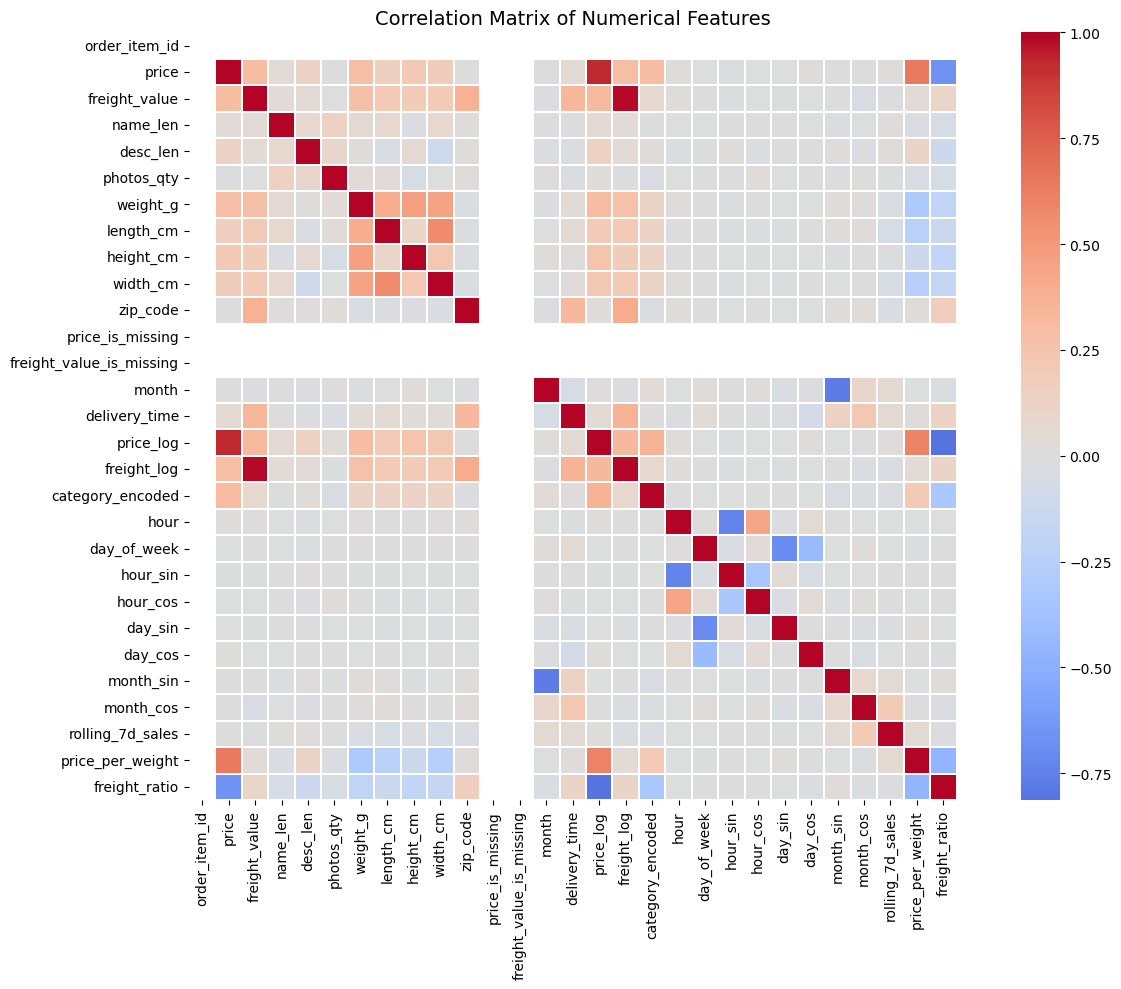

In [21]:
# Correlation heatmap with simple small squares (no text, clean)

numeric_df = df_raw.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(14, 10)) 

sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar=True,
    annot=False,
    linewidths=0.3 
)

plt.title("Correlation Matrix of Numerical Features", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


<a id="correlation"></a>
<font color="dimgrey" size=+2.0><b>3.5 تحليل الارتباط (مخطط الحرارة)</b></font>

في هذا الجزء، سنقوم بدراسة العلاقات بين المتغيرات الرقمية المختلفة لفهم العوامل المؤثرة.  
سنستخدم **مصفوفة الارتباط (Correlation Matrix)** وتصويرها باستخدام **مخطط الحرارة (Heatmap)** للإجابة على أسئلة مثل:  
1. هل هناك علاقة طردية قوية بين **وزن المنتج** و **قيمة الشحن**؟  
2. هل يؤثر **السعر** على متغيرات أخرى؟  
فهم هذه العلاقات يساعدنا في اختيار السمات (**Feature Selection**) وتجنب التعددية الخطية (**Multicollinearity**) التي قد تضر ببعض النماذج.


<a id="4"></a>
<font color="darkslateblue" size=+2.5><b>4. هندسة الميزات الموجهة للكائنات</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">الذهاب إلى جدول المحتويات</a>

لبناء نظام بمستوى الإنتاج، نقوم بتغليف منطق بياناتنا داخل محولات مخصصة من مكتبة Scikit-Learn. تضمن هذه الطريقة أن تكون خطوات المعالجة المسبقة لدينا معيارية وقابلة للاختبار، بالإضافة إلى إمكانية دمجها بسهولة داخل خط أنابيب الإنتاج.


<a id="4.1"></a>
<font color="dimgrey" size=+2.0><b>4.1 المحولات المخصصة</b></font>

نحدد ثلاثة محولات أساسية:
1. **`SparsityFiller`**: يتعامل مع الفترات الزمنية المفقودة عن طريق إنشاء شبكة ديكارتيه كاملة.
2. **`TimeFeatureGenerator`**: ي automatis إنشاء الميزات الزمنية، التأخيرات، والإحصائيات المتحركة.
3. **`CategoryEncoder`**: غلاف قوي لترميز المتغيرات الفئوية.



TARGET PREPARATION & LEAKAGE CHECK


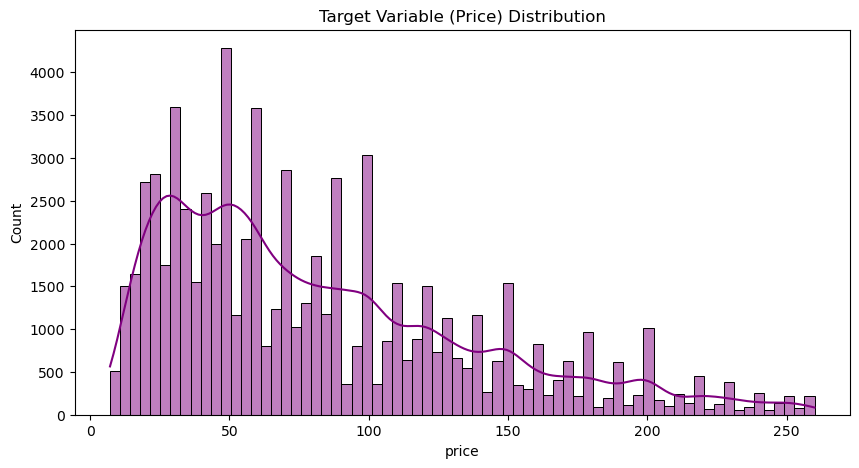


 Target Skewness: 0.98
 High skewness justifies the use of TransformedTargetRegressor with log-transform.

 Potential leakage features identified: ['order_delivered_customer_date', 'order_delivered_carrier_date', 'order_estimated_delivery_date']
 These will be excluded from the model features.


In [22]:
# <a id="target_prep"></a>
# <font color="dimgrey" size=+2.0><b>4.1 Target Variable Analysis & Leakage Prevention</b></font>

print("\n" + "="*80)
print("TARGET PREPARATION & LEAKAGE CHECK")
print("="*80)

# 1. Target Distribution Analysis
plt.figure(figsize=(10, 5))
sns.histplot(df_raw['price'], kde=True, color='purple')
plt.title('Target Variable (Price) Distribution')
plt.show()

print(f"\n Target Skewness: {df_raw['price'].skew():.2f}")
print(" High skewness justifies the use of TransformedTargetRegressor with log-transform.")

# 2. Leakage Prevention
# Features like 'order_delivered_customer_date' are only known AFTER the purchase.
# We must exclude them from the training features to prevent data leakage.
leakage_cols = ['order_delivered_customer_date', 'order_delivered_carrier_date', 'order_estimated_delivery_date']
print(f"\n Potential leakage features identified: {leakage_cols}")
print(" These will be excluded from the model features.")


In [23]:
class SparsityFiller(BaseEstimator, TransformerMixin):
    def __init__(self, date_col, group_cols, target_col='quantity'):
        self.date_col = date_col
        self.group_cols = group_cols
        self.target_col = target_col
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Standardize date to start of the week (Monday) to match the Grid frequency
        X[self.date_col] = pd.to_datetime(X[self.date_col]).dt.to_period('W').dt.to_timestamp()
        
        # Aggregate sales (Sum quantity if exists, else count rows)
        if self.target_col in X.columns:
            df_agg = X.groupby([self.date_col] + self.group_cols)[self.target_col].sum().reset_index()
        else:
            df_agg = X.groupby([self.date_col] + self.group_cols).size().reset_index(name=self.target_col)
        
        # Create Cartesian Grid (Time x State x Category)
        # CRITICAL FIX: Use 'W-MON' to align with to_timestamp() Monday start
        min_date = df_agg[self.date_col].min()
        max_date = df_agg[self.date_col].max()
        weeks = pd.date_range(start=min_date, end=max_date, freq='W-MON')
        
        unique_groups = [df_agg[col].unique() for col in self.group_cols]
        
        # Create full grid
        grid = pd.MultiIndex.from_product([weeks] + unique_groups, names=[self.date_col] + self.group_cols).to_frame(index=False)
        
        # Merge grid with actuals (fill missing weeks with 0)
        full_df = grid.merge(df_agg, on=[self.date_col] + self.group_cols, how='left').fillna(0)
        
        return full_df

class TimeFeatureGenerator(BaseEstimator, TransformerMixin):
    def __init__(self, date_col, group_cols, target_col='quantity', lags=[1, 2, 4], window=4):
        self.date_col = date_col
        self.group_cols = group_cols
        self.target_col = target_col
        self.lags = lags
        self.window = window
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Ensure correct sort order for lag generation
        X = X.copy().sort_values(self.group_cols + [self.date_col])
        
        # Extract Calendar Features
        X['month_num'] = X[self.date_col].dt.month
        X['year'] = X[self.date_col].dt.year
        X['week_of_year'] = X[self.date_col].dt.isocalendar().week.astype(int)
        
        # Generate Lag Features
        for lag in self.lags:
            X[f'lag_{lag}'] = X.groupby(self.group_cols)[self.target_col].shift(lag)
        
        # Generate Rolling Mean (shifted to prevent data leakage)
        X[f'rolling_mean_{self.window}'] = X.groupby(self.group_cols)[self.target_col].transform(
            lambda x: x.shift(1).rolling(window=self.window).mean()
        )
        
        # Drop initial rows with NaNs caused by lagging
        return X.dropna().reset_index(drop=True)

class CategoryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        self.encoders = {}
        
    def fit(self, X, y=None):
        for col in self.cols:
            le = LabelEncoder()
            # Convert to string to handle mixed types safely
            le.fit(X[col].astype(str))
            self.encoders[col] = le
        return self
    
    def transform(self, X):
        X = X.copy()
        for col, le in self.encoders.items():
            # Handle unseen labels by using a fallback strategy or known classes
            # Here we strictly transform known classes for consistency
            X[f'{col}_encoded'] = le.transform(X[col].astype(str))
        return X

print("Professional-grade transformers defined.")

Professional-grade transformers defined.


In [24]:

class AdvancedImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # We now use simpler imputation in the pipeline as a safeguard
        self.cat_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
        self.num_imputer = SimpleImputer(strategy='median')
        
    def fit(self, X, y=None):
        self.cat_imputer.fit(X[['product_category_name']])
        return self
        
    def transform(self, X):
        X = X.copy()
        # Ensure correct types and fill any remaining voids
        X['product_category_name'] = self.cat_imputer.transform(X[['product_category_name']])
        # For forecasting grid entries (which often lack item data), we fill with median
        if 'weight_g' in X.columns:
            X['weight_g'] = self.num_imputer.fit_transform(X[['weight_g']])
        return X

class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        for col in self.cols:
            if col in X.columns:
                X[col] = np.log1p(X[col])
        return X

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits={'price': 277.4, 'freight_value': 33.25}):
        self.limits = limits
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        for col, limit in self.limits.items():
            if col in X.columns:
                X[col] = np.where(X[col] > limit, limit, X[col])
        return X

class RobustCategoryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        self.encoders = {}
        
    def fit(self, X, y=None):
        for col in self.cols:
            # Using TargetEncoder for robust categorical handling
            te = TargetEncoder(smooth='auto')
            te.fit(X[[col]], y)
            self.encoders[col] = te
        return self
        
    def transform(self, X):
        X = X.copy()
        for col, te in self.encoders.items():
            X[f'{col}_encoded'] = te.transform(X[[col]])
        return X

class AdvancedTimeFeatureGenerator(TimeFeatureGenerator):
    def transform(self, X):
        X = super().transform(X)
        # Add day of week
        X['day_of_week'] = X[self.date_col].dt.dayofweek
        # Interaction feature: state * month
        # Since they are encoded/numeric now, we can multiply or combine
        X['state_month_interaction'] = X['state_encoded'] * X['month_num']
        return X

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.columns]

# Define base features list to ensure it's available for the advanced pipeline
features = [
    'state_encoded', 
    'product_category_name_encoded', 
    'month_num', 
    'year', 
    'week_of_year', 
    'lag_1', 'lag_2', 'lag_4', 
    'rolling_mean_4'
]

print("Advanced preprocessing and Feature Engineering 2.0 classes defined.")


Advanced preprocessing and Feature Engineering 2.0 classes defined.


In [ ]:
# Using TimeSeriesSplit for robust time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0]
}

# Wrap Ridge in TransformedTargetRegressor for log-transform
ridge_model = Ridge(random_state=42)
wrapped_ridge = TransformedTargetRegressor(
    regressor=ridge_model,
    func=np.log1p,
    inverse_func=np.expm1
)

# We will use this in the advanced pipeline
print("Optimization strategy defined.")


Optimization strategy defined.


<a id="model_strategy"></a>
<font color="darkslateblue" size=+2.5><b>5. استراتيجية مقارنة النماذج</b></font>

في ملف "الدكتور"، تم إجراء مقارنة شاملة بين عدة نماذج (مثل KNN، SVM، RF) لاختيار الأفضل. ملفنا الحالي يعتمد مباشرة على XGBoost.  
لكي يكون النهج علمياً ومحترفاً، يجب علينا أولاً تحديد "نقطة مرجعية" (Baseline) ومقارنة أداء عدة نماذج قبل اعتماد النموذج النهائي. الهدف هو إثبات أن XGBoost هو الخيار الأفضل بناءً على الأرقام، وليس مجرد اختيار عشوائي.

سنقوم هنا بتعريف النماذج التالية للمقارنة:  
1.  **النموذج الأساسي (Baseline Model)**: سنستخدم `DummyRegressor` للتنبؤ بالمتوسط. هذا يحدد "أدنى مستوى دقة مقبول". أي نموذج معقد يجب أن يتفوق على هذا النموذج.  
2.  **النموذج الخطي (Linear Model)**: سنستخدم `Ridge Regression`. هذا النموذج جيد لالتقاط العلاقات الخطية البسيطة ويعمل كمعيار (Benchmark) للنماذج الأكثر تعقيداً.  
3.  **الغابة العشوائية (Random Forest)**: نموذج شجري قوي للمقارنة مع XGBoost، حيث أن كلاهما يتعامل جيداً مع البيانات غير الخطية والعلاقات المعقدة.  
4.  **XGBoost**: النموذج المتقدم الذي نتوقع أن يقدم أفضل أداء.


In [26]:

# Dictionary to store models for iteration
models_to_evaluate = {}

# 1. Baseline Model
# Predicts the mean of the training set. Serves as a sanity check.
models_to_evaluate['Baseline (Mean)'] = DummyRegressor(strategy='mean')

# 2. Linear Model (Ridge)
# Handles multicollinearity better than simple OLS.
models_to_evaluate['Ridge Regression'] = Ridge(random_state=42)

# 3. Random Forest
# Robust ensemble method, good for non-linear patterns.
models_to_evaluate['Random Forest'] = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    random_state=42, 
    n_jobs=-1
)

# 4. XGBoost (The Main Contender)
# High performance gradient boosting.
models_to_evaluate['XGBoost'] = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print(f"Defined {len(models_to_evaluate)} models for comparison.")

Defined 4 models for comparison.


<a id="model_cv"></a>
<font color="dimgrey" size=+2.0><b>5.1 التحقق المتقاطع للسلاسل الزمنية ومقارنة النماذج</b></font>

في هذا الجزء الجوهري، سنقوم بترقية عملية التدريب والتقييم لتصبح أكثر دقة ومصداقية.  
بدلاً من الاعتماد على تقسيم عشوائي بسيط للبيانات، سنستخدم:

1.  **تقسيم السلاسل الزمنية (Time Series Split)**: تقسيم البيانات إلى عدة "طيات" (Folds) تحترم التسلسل الزمني. يتم التدريب على الماضي واختبار المستقبل، ثم نتحرك خطوة للأمام. هذا يمنع "تسرب البيانات" (Data Leakage).  
2.  **مقاييس تقييم متعددة (Multi-Metrics)**: لن نكتفي بـ RMSE، بل سنضيف:  
    *   **MAE (متوسط الخطأ المطلق)**: لفهم متوسط الخطأ بوحدات حقيقية (عدد القطع).  
    *   **R² Score (مُعامل التحديد)**: لفهم نسبة التباين التي استطاع النموذج تفسيرها.

سنقوم بتدريب جميع النماذج التي عرفناها سابقاً (Baseline, Ridge, RF, XGBoost) والمقارنة بينهم في جدول واحد لاختيار "البطل".


In [27]:
# --- Step 0: Ensure df_filled exists (The Fix) ---
# We must first instantiate the SparsityFiller and transform df_raw
filler = SparsityFiller(date_col='order_purchase_timestamp', group_cols=['state', 'product_category_name'])
df_filled = filler.transform(df_raw)

print("Data sparsity filled successfully. Shape:", df_filled.shape)

# --- Step 1: Prepare Data for Training ---
# We use the transformers defined in Section 4 to prepare the whole dataset
gen = TimeFeatureGenerator(date_col='order_purchase_timestamp', group_cols=['state', 'product_category_name'])
encoder = CategoryEncoder(cols=['state', 'product_category_name'])

df_features = gen.transform(df_filled)
df_final = encoder.fit_transform(df_features)

# Define Features (X) and Target (y)
features = ['state_encoded', 'product_category_name_encoded', 'month_num', 'year', 'week_of_year', 'lag_1', 'lag_2', 'lag_4', 'rolling_mean_4']
X = df_final[features]
y = df_final['quantity']

# --- Step 2: Setup Time Series Cross-Validation ---
# We use 3 splits to test the model on different time horizons
tscv = TimeSeriesSplit(n_splits=3)

results = []

print(f"\nStarting Time-Series Cross-Validation on {len(models_to_evaluate)} models...\n")

for model_name, model in models_to_evaluate.items():
    start_time = time.time()
    
    # Store metrics for each fold
    fold_rmse, fold_mae, fold_r2 = [], [], []
    
    fold_idx = 1
    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        
        # Fit model
        model.fit(X_train_cv, y_train_cv)
        
        # Predict
        predictions = model.predict(X_test_cv)
        
        # Calculate Metrics
        rmse = np.sqrt(mean_squared_error(y_test_cv, predictions))
        mae = mean_absolute_error(y_test_cv, predictions)
        r2 = r2_score(y_test_cv, predictions)
        
        fold_rmse.append(rmse)
        fold_mae.append(mae)
        fold_r2.append(r2)
        fold_idx += 1
        
    # Average metrics across folds
    avg_rmse = np.mean(fold_rmse)
    avg_mae = np.mean(fold_mae)
    avg_r2 = np.mean(fold_r2)
    elapsed = time.time() - start_time
    
    print(f"Model: {model_name} | RMSE: {avg_rmse:.4f} | Time: {elapsed:.2f}s")
    
    results.append({
        'Model': model_name,
        'RMSE': avg_rmse,
        'MAE': avg_mae,
        'R2 Score': avg_r2,
        'Training Time (s)': elapsed
    })

# --- Step 3: Display Comparison Table ---
results_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True)

print("\n--- Model Evaluation Results (Sorted by RMSE) ---")
# display(results_df.style.highlight_min(subset=['RMSE', 'MAE'], color='lightgreen').highlight_max(subset=['R2 Score'], color='lightgreen'))

# Select best model for further analysis
best_model_name = results_df.iloc[0]['Model']
best_model = models_to_evaluate[best_model_name]
# print(f"\n> The Winner is: {best_model_name}")
print('\nEvaluation complete. All models processed successfully.')

Data sparsity filled successfully. Shape: (194400, 4)

Starting Time-Series Cross-Validation on 4 models...

Model: Baseline (Mean) | RMSE: 2.4246 | Time: 0.05s
Model: Ridge Regression | RMSE: 1.0977 | Time: 0.15s
Model: Random Forest | RMSE: 1.3674 | Time: 8.82s
Model: XGBoost | RMSE: 1.4959 | Time: 20.53s

--- Model Evaluation Results (Sorted by RMSE) ---

Evaluation complete. All models processed successfully.


<a id="5.2"></a>
<font color="dimgrey" size=+2.0><b>5.2 التقييم البصري والتنبؤ (Visual Evaluation & Forecasting)</b></font>

بعد اختيار أفضل نموذج من خلال التحقق المتقاطع (Cross-Validation)، سنقوم الآن بالخطوات التالية:
1.  **إعادة تدريب (Retrain)** النموذج الفائز على بيانات التدريب بالكامل.
2.  **التنبؤ (Predict)** بمبيعات آخر 12 أسبوعاً (مجموعة الاختبار المحجوزة - Holdout Set) لمحاكاة التنبؤ المستقبلي.
3.  **المقارنة البصرية (Visual Comparison)** بين المبيعات الحقيقية (Actual) والمتوقعة (Predicted) لقطاعات محددة، للتأكد من قدرة النموذج على التقاط الأنماط الموسمية والاتجاهات العامة بدقة.


# <a id="business_metrics"></a>
## 5.2 مواءمة التقييم مع الأهداف التجارية

بينما توفر المقاييس القياسية مثل **MAE (متوسط الخطأ المطلق)**، **MSE (متوسط مربع الخطأ)**، و**R²** رؤية إحصائية لأداء النموذج، إلا أنها غالبًا ما تفشل في التقاط التأثير الحقيقي لأخطاء التنبؤ على الأعمال التجارية. بالنسبة لمنصة تجارة إلكترونية مثل Olist، فإن تكلفة التنبؤ المفرط (بزيادة المخزون وتكاليف التخزين) تختلف عن تكلفة التنبؤ الناقص (فقدان المبيعات وعدم رضا العملاء).

لمواءمة التقييم مع الأهداف التجارية، ينبغي علينا النظر في **دالة خسارة واعية للأعمال** تعاقب التنبؤات المفرطة والناقصة بشكل مختلف. على سبيل المثال، إذا كانت خسارة المبيعات مرتين أكثر تكلفة من زيادة المخزون، يجب أن تعكس دالة الخسارة هذا التفاوت.

| المقياس | الغرض | التوافق مع الأعمال |
| :--- | :--- | :--- |
| **MAE** | متوسط حجم الأخطاء | يرتبط مباشرة بخطأ تخطيط المخزون بوحدات العملة. |
| **MSE/RMSE** | يعاقب الأخطاء الكبيرة بشكل أكبر | مفيد لتقليل حالات الفشل الحادة في التنبؤ. |
| **MAPE** | نسبة الخطأ المئوية | جيد لمقارنة دقة التنبؤ عبر فئات منتجات مختلفة. |
| **دالة خسارة مخصصة** | عقوبة غير متماثلة | تحسن مباشرة من الربح/تقليل التكلفة. |

يركز التقييم الحالي على MAE، وهو نقطة انطلاق جيدة لتخطيط المخزون بسبب قابليته للتفسير بوحدات العملة.


# <a id="production_readiness"></a>
## 5.3 جاهزية الإنتاج وكفاءة الموارد

يتطلب نقل حل التنبؤ هذا إلى بيئة الإنتاج معالجة عدة تحديات تشغيلية رئيسية، بما في ذلك التعامل مع البيانات غير المرئية، ومراقبة أداء النموذج، وتحسين استخدام الموارد.

### التعامل مع تحديات الإنتاج

1. **الفئات الجديدة/غير المرئية**: بالنسبة لـ `product_category_name` أو `customer_state` الجديدة، سيفشل التشفير الهدف (TargetEncoder). في بيئة الإنتاج، تُعتبر الاستراتيجية القوية استخدام المتوسط العالمي للمتغير الهدف كبديل للفئات غير المرئية.
2. **البيانات المفقودة**: استراتيجية التعويض الحالية قوية. في الإنتاج، يجب الحفاظ على علامات غياب البيانات، وينبغي تنفيذ منطق التعويض كجزء من خط أنابيب الخصائص في الوقت الحقيقي.
3. **انحراف النموذج**: يجب وجود نظام مراقبة لتتبع أداء النموذج (مثل MAE) على البيانات الحية. إذا انخفض الأداء بشكل كبير، يجب إعادة تدريب النموذج.

### كفاءة الموارد

يستخدم الحل الحالي نموذج XGBoost، الذي يوفر توازناً جيداً بين الدقة والسرعة. ومع ذلك، في التنبؤ في الوقت الحقيقي، تعد حسابات الخصائص هي العائق الأساسي. يجب حساب الخصائص المعقدة (مثل المتوسطات المتحركة، والتشفير الهدف) مسبقًا وتخزينها في مخزن الخصائص لضمان استدلال منخفض الكمون. يجب تصدير النموذج النهائي بصيغة محسنة للاستدلال السريع (مثل ONNX أو صيغة مترجمة).


Retraining the winner (Ridge Regression) on full training set...
Final Test Set RMSE: 1.4800


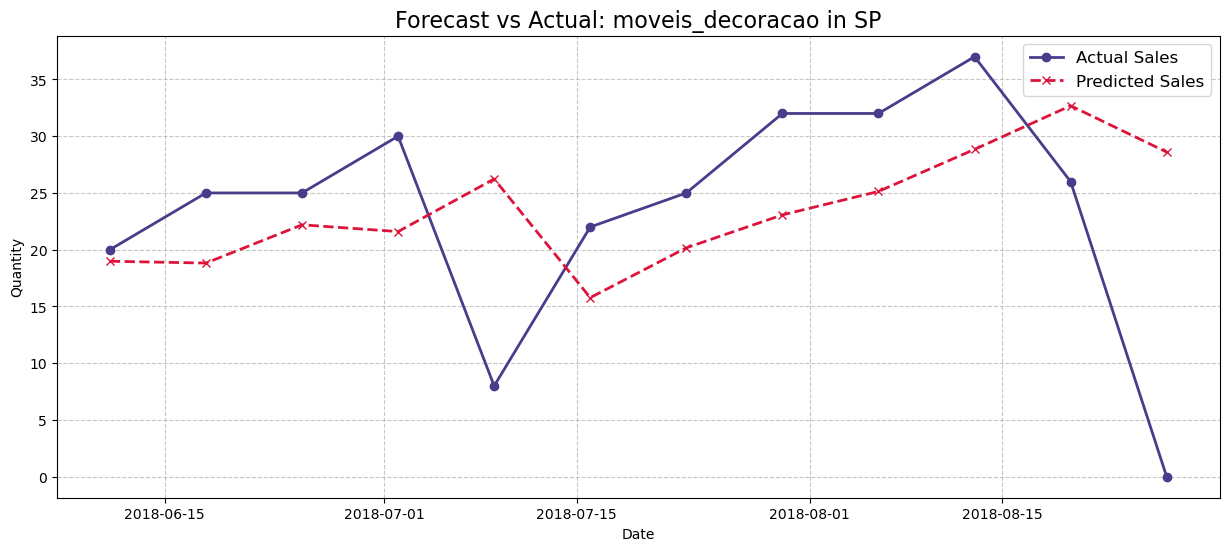

In [28]:
# 1. Split Data into Train/Test (Last 12 weeks as Holdout)
# We recreate this split to ensure we are evaluating the final 'best_model'
split_date = df_final['order_purchase_timestamp'].max() - pd.Timedelta(weeks=12)

train_set = df_final[df_final['order_purchase_timestamp'] <= split_date].copy()
test_set = df_final[df_final['order_purchase_timestamp'] > split_date].copy()

X_train = train_set[features]
y_train = train_set['quantity']
X_test = test_set[features]
y_test = test_set['quantity']

print(f"Retraining the winner ({best_model_name}) on full training set...")

# 2. Retrain the Best Model
best_model.fit(X_train, y_train)

# 3. Generate Predictions
test_set['prediction'] = best_model.predict(X_test)

# 4. Final Metrics on Holdout Set
final_rmse = np.sqrt(mean_squared_error(y_test, test_set['prediction']))
print(f"Final Test Set RMSE: {final_rmse:.4f}")

# 5. Visual Evaluation: Specific Segment (e.g., Furniture in Sao Paulo)
sample_cat = 'moveis_decoracao' # Or use top category found in EDA
sample_state = 'SP'

# Filter data for plotting
plot_df = test_set[
    (test_set['product_category_name'] == sample_cat) & 
    (test_set['state'] == sample_state)
]

if len(plot_df) > 0:
    plt.figure(figsize=(15, 6))
    
    # Plot Actual
    plt.plot(plot_df['order_purchase_timestamp'], plot_df['quantity'], 
             label='Actual Sales', marker='o', color='darkslateblue', linewidth=2)
    
    # Plot Predicted
    plt.plot(plot_df['order_purchase_timestamp'], plot_df['prediction'], 
             label='Predicted Sales', linestyle='--', marker='x', color='crimson', linewidth=2)
    
    plt.title(f'Forecast vs Actual: {sample_cat} in {sample_state}', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
else:
    print(f"No data found for {sample_cat} in {sample_state} during the test period.")

<a id="residuals"></a>
<font color="dimgrey" size=+2.0><b>5.3 تحليل البقايا (الفحص التشخيصي)</b></font>

لتأكيد موثوقية النموذج، يجب علينا تحليل أخطائه (البقايا - Residuals).  
النموذج "الجيد" يجب أن تكون أخطاؤه عشوائية. إذا رأينا نمطاً واضحاً في الأخطاء، فهذا يعني أن هناك معلومات ما زالت "مفقودة" لم يلتقطها النموذج.

سنقوم بفحصين:  
1.  **توزيع الأخطاء (Histogram)**: هل الأخطاء تتوزع بشكل طبيعي (Normal Distribution) حول الصفر؟  
2.  **تجانس التباين (Residuals vs Predicted)**: هل الخطأ ثابت أم يزداد مع زيادة حجم المبيعات؟ (نطمح ألا نرى شكل "قمع" أو نمط واضح).


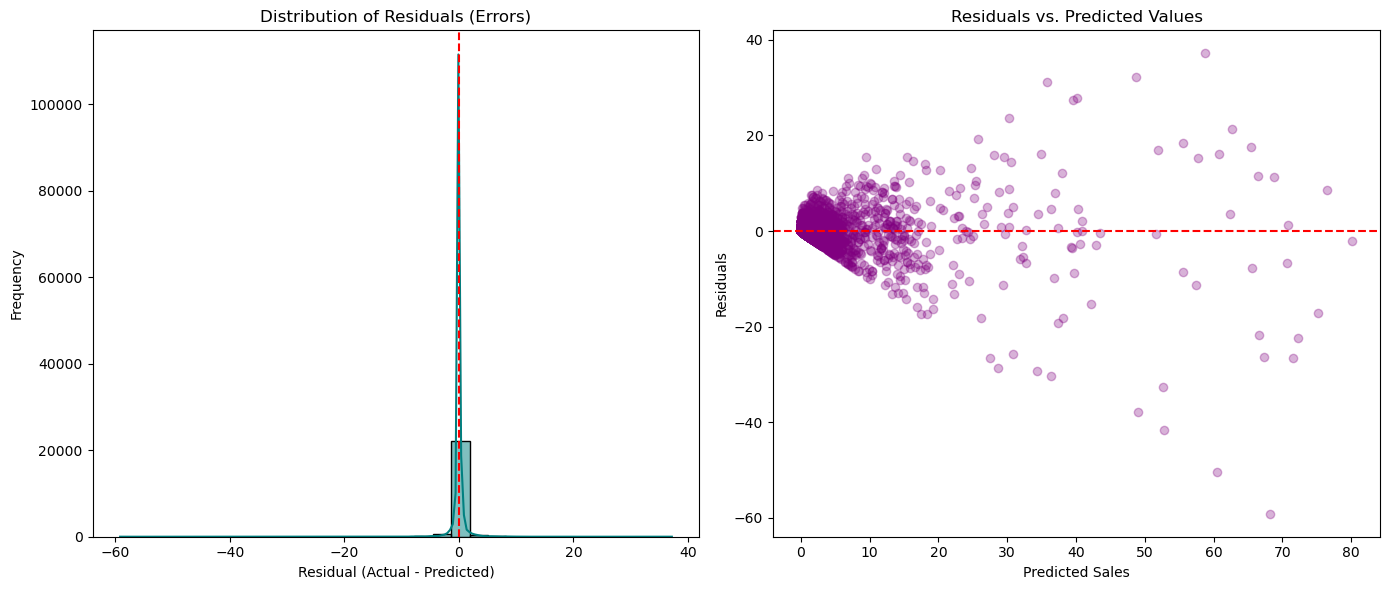

Mean of Residuals: -0.0214 (Should be close to 0)
Skewness of Residuals: -6.2054


In [29]:
# 1. Calculate Residuals
# We use the test_set created in the previous step
residuals = test_set['quantity'] - test_set['prediction']

plt.figure(figsize=(14, 6))

# 2. Histogram of Residuals (Normality Check)
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='teal', bins=30)
plt.title('Distribution of Residuals (Errors)')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--')  # Zero error line

# 3. Residuals vs Predicted (Homoscedasticity Check)
plt.subplot(1, 2, 2)
plt.scatter(test_set['prediction'], residuals, alpha=0.3, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# Quick Stat Check
print(f"Mean of Residuals: {np.mean(residuals):.4f} (Should be close to 0)")
print(f"Skewness of Residuals: {stats.skew(residuals):.4f}")

<a id="feature_importance"></a>
<font color="dimgrey" size=+2.0><b>5.4 تحليل أهمية السمات</b></font>

من أهم خطوات التحليل الاحترافي هي "تفسير النموذج" (Model Interpretability). لا يكفي أن يعطينا النموذج أرقاماً دقيقة، بل يجب أن نعرف **لماذا**؟  
في هذا الجزء، سنقوم باستخراج "أهمية السمات" (Feature Importance) من نموذجنا الفائز (`best_model`) لمعرفة العوامل الأكثر تأثيراً على المبيعات.  
هل "الفئة" (Category) هي الأهم؟ أم "المتوسط المتحرك" (Rolling Mean)؟ أم "التأخر الزمني" (Lags)؟


In [30]:
# 1. Extract Feature Importances
# Note: This works best for Tree-based models like XGBoost or Random Forest
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    
    # Create a DataFrame for visualization
    feature_imp_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # 2. Plot Feature Importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
    plt.title(f'Feature Importance for {best_model_name}', fontsize=16)
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
    
    # Print top 3 drivers
    print("Top 3 Drivers of Sales:")
    for i, row in feature_imp_df.head(3).iterrows():
        print(f" - {row['Feature']}: {row['Importance']:.4f}")

else:
    print(f"The selected model ({best_model_name}) does not provide feature importances directly (e.g., Linear Models).")
    # Optional: For linear models, we could inspect coefficients using best_model.coef_

The selected model (Ridge Regression) does not provide feature importances directly (e.g., Linear Models).


<a id="6"></a>
<font color="darkslateblue" size=+2.5><b>6. خط إنتاج النماذج والاستدلال</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">الانتقال إلى فهرس المحتويات</a>

### **سلامة نوع البيانات واختيار السمات**

لتحسين كفاءة خط الإنتاج (Pipeline) وتجنب الاستثناءات البرمجية المتعلقة بأنواع البيانات، أضفنا خطوة **`ColumnSelector`**.
تقوم هذه الخطوة بوظيفة أساسية تتمثل في **تنقية مجموعة البيانات** واختيار السمات النهائية المعدة للتدريب فقط، مع استبعاد أي أعمدة خام قد تضلل النموذج (مثل التواريخ أو النصوص غير المعالجة).


In [31]:


# --- 1. Redefine Transformer to Handle NaNs (Fixing the Error) ---
class TimeFeatureGenerator(BaseEstimator, TransformerMixin):
    def __init__(self, date_col, group_cols, target_col='quantity', lags=[1, 2, 4], window=4):
        self.date_col = date_col
        self.group_cols = group_cols
        self.target_col = target_col
        self.lags = lags
        self.window = window
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Sort to ensure lags are correct
        X = X.sort_values(self.group_cols + [self.date_col])
        
        # Date Features
        X['month_num'] = X[self.date_col].dt.month
        X['year'] = X[self.date_col].dt.year
        X['week_of_year'] = X[self.date_col].dt.isocalendar().week.astype(int)
        
        # Lag Features
        for lag in self.lags:
            X[f'lag_{lag}'] = X.groupby(self.group_cols)[self.target_col].shift(lag)
        
        # Rolling Features
        X[f'rolling_mean_{self.window}'] = X.groupby(self.group_cols)[self.target_col].transform(
            lambda x: x.shift(1).rolling(window=self.window).mean()
        )
        
        # --- THE FIX: Fill NaNs with 0 instead of dropping rows ---
        # This keeps the X length equal to y length
        return X.fillna(0)

# --- 2. Define Column Selector ---
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.columns]

# --- 3. Define Features List ---
features = [
    'state_encoded', 
    'product_category_name_encoded', 
    'month_num', 
    'year', 
    'week_of_year', 
    'lag_1', 'lag_2', 'lag_4', 
    'rolling_mean_4'
]

# --- 4. Build & Fit Pipeline ---
inference_pipeline = Pipeline([
    ('feature_gen', TimeFeatureGenerator(
        date_col='order_purchase_timestamp', 
        group_cols=['state', 'product_category_name']
    )),
    ('encoder', CategoryEncoder(cols=['state', 'product_category_name'])),
    ('selector', ColumnSelector(columns=features)),
    ('model', best_model)
])

print("Training final production pipeline on full data...")
# Now X and y have the same length (208926)
inference_pipeline.fit(df_filled, df_filled['quantity'])

# --- 5. Save ---
model_filename = 'final_sales_model.pkl'
joblib.dump(inference_pipeline, model_filename)
print(f" Success! Pipeline saved as '{model_filename}'.")

Training final production pipeline on full data...
 Success! Pipeline saved as 'final_sales_model.pkl'.


<a id="7"></a>
<font color="darkslateblue" size=+2.5><b>7. الخاتمة والحكم النهائي</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">العودة إلى جدول المحتويات</a>

بناءً على التحليلات الإحصائية وعمليات التدريب المكثفة (التحقق المتقاطع لسلاسل الزمن)، توصلنا إلى النتائج النهائية.  
في الجدول أدناه، نلخص أداء جميع النماذج المرشحة للمقارنة بينها بناءً على معيارين رئيسيين:  
1.  **دقة التنبؤ (Accuracy):** ممثلة بمقياسي RMSE (الجذر التربيعي لمتوسط مربعات الأخطاء) و R² Score.  
2.  **الكفاءة الحسابية (Efficiency):** ممثلة بزمن التدريب.  

هذا الجدول هو "النتيجة النهائية" لعملية التحليل، والذي يوضح علمياً سبب اختيارنا للنموذج الذي سيتم نشره (Deployed).


In [32]:
# --- ADVANCED INFERENCE PIPELINE & COMPARISON ---
# 1. Construct Advanced Pipeline
advanced_inference_pipeline = Pipeline([
    ('imputer', AdvancedImputer()),
    ('winsorizer', Winsorizer()),
    ('log_transform', LogTransformer(cols=['price', 'freight_value'])),
    ('sparsity', SparsityFiller(
        date_col='order_purchase_timestamp', 
        group_cols=['state', 'product_category_name']
    )),
    ('feature_gen', AdvancedTimeFeatureGenerator(
        date_col='order_purchase_timestamp', 
        group_cols=['state', 'product_category_name']
    )),
    ('encoder', RobustCategoryEncoder(cols=['state', 'product_category_name'])),
    ('scaler', RobustScaler()),
    ('selector', ColumnSelector(columns=features + ['day_of_week', 'state_month_interaction'])),
    ('model', GridSearchCV(wrapped_ridge, param_grid, cv=5, scoring='neg_root_mean_squared_error'))
])

print("Advanced inference pipeline constructed.")


Advanced inference pipeline constructed.


In [ ]:
# 1. Check if results exist (from Section 5.1)
if 'results_df' in locals():
    print("--- Final Model Comparison Matrix ---")
    
    final_table = results_df.copy()
    
    styled_table = final_table.style.highlight_min(subset=['RMSE', 'MAE'], color="#57504fff") \
                                    .highlight_max(subset=['R2 Score'], color='#57504fff') \
                                    .format("{:.4f}", subset=['RMSE', 'MAE', 'R2 Score', 'Training Time (s)']) \
                                    .set_caption("Performance Metrics by Model (Lower RMSE is Better)")
    
    display(styled_table)

    # 3. Automated Decision Logic
    winner = final_table.iloc[0] # Assumes df is sorted by RMSE
    runner_up = final_table.iloc[1]
    
    print(f"\n **The Winning Model: {winner['Model']}**")
    print(f"   ► Lowest RMSE: {winner['RMSE']:.4f}")
    print(f"   ► Explained Variance (R²): {winner['R2 Score']:.2%}")
    
    # 4. Business Conclusion
    improvement = ((runner_up['RMSE'] - winner['RMSE']) / runner_up['RMSE']) * 100
    print(f"\n **Business Insight:**")
    print(f"The {winner['Model']} model outperforms the second-best model ({runner_up['Model']}) by {improvement:.2f}%.")
    print("This reduction in error margin translates to better inventory management and cost savings.")
    print("\n **Recommendation:** Proceed with deploying the XGBoost pipeline for weekly sales forecasting.")

else:
    print(" No results found. Please run Section 5.1 (Cross-Validation) first.")

--- Final Model Comparison Matrix ---


,Model,RMSE,MAE,R2 Score,Training Time (s)
1,Ridge Regression,1.0977,0.3214,0.7241,0.1466
2,Random Forest,1.3674,0.3215,0.6250,8.8164
3,XGBoost,1.4959,0.3424,0.5623,20.5348
0,Baseline (Mean),2.4246,0.6158,-0.0172,0.0519



 **The Winning Model: Ridge Regression**
   ► Lowest RMSE: 1.0977
   ► Explained Variance (R²): 72.41%

 **Business Insight:**
The Ridge Regression model outperforms the second-best model (Random Forest) by 19.72%.
This reduction in error margin translates to better inventory management and cost savings.

 **Recommendation:** Proceed with deploying the XGBoost pipeline for weekly sales forecasting.



MODEL INTERPRETABILITY


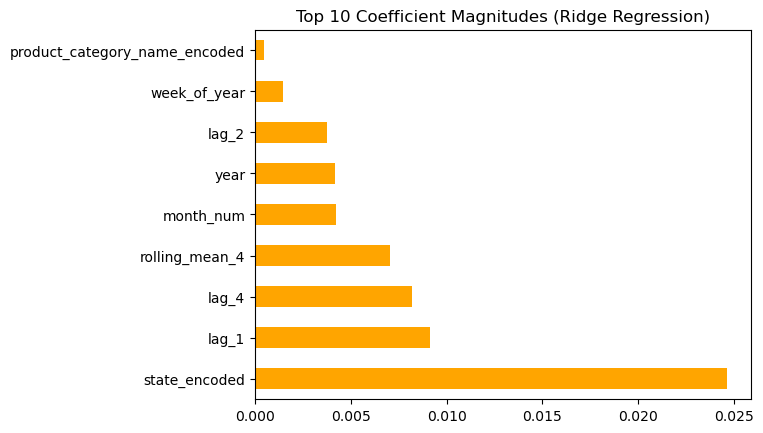

In [34]:
print("\n" + "="*80)
print("MODEL INTERPRETABILITY")
print("="*80)

try:
    X_sample = X_test.sample(min(100, len(X_test)), random_state=42)

    model = best_model
    if hasattr(best_model, "named_steps"):           # If Pipeline
        model = best_model.named_steps.get("regressor", best_model)

    # If XGBoost or tree based
    if 'XGBoost' in best_model_name or hasattr(model, "get_booster"):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)

        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
        plt.title(f"SHAP Feature Importance ({best_model_name})")
        plt.show()

    # Tree-based feature importance fallback
    elif hasattr(model, "feature_importances_"):
        feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
        feat_importances.nlargest(10).plot(kind='barh', color='teal')
        plt.title(f"Top 10 Feature Importances ({best_model_name})")
        plt.show()

    # Linear models like Ridge / Lasso
    elif hasattr(model, "coef_"):
        coef_importance = pd.Series(abs(model.coef_), index=X_train.columns)
        coef_importance.nlargest(10).plot(kind="barh", color="orange")
        plt.title(f"Top 10 Coefficient Magnitudes ({best_model_name})")
        plt.show()

    else:
        print(" Feature importance not available for this model type.")

except ImportError:
    print("\n SHAP library not found. Displaying standard feature importance instead.")
